# Analysing News Article Content with Google Cloud Natural Language API


## Imports and Setup


In [1]:
%load_ext autoreload
%autoreload 2

import requests
import time
import numpy as np
import pandas as pd
from pprint import pprint
from google.cloud import bigquery

from functools import partial
import concurrent.futures
import multiprocessing
from tqdm import tqdm
tqdm.pandas()

num_processes = multiprocessing.cpu_count()

from utils import analyze_article, draw_boxplot_histogram

PROJECT = "aliz-ml-spec-2022-dev"
DATASET = "ml_specialization"
TABLE = "articles"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)


# Table Creation

In [2]:
PROJECT = "aliz-ml-spec-2022-dev"
DATASET = "ml_specialization"
TABLE = "articles"

In [19]:
# Create dataset
bq_client = bigquery.Client()
bq_client.create_dataset(DATASET, exists_ok = True)
dataset_ref = bigquery.DatasetReference(PROJECT, DATASET)

# create date-partitioned table
SCHEMA = [
    bigquery.SchemaField("insert_datetime", "DATETIME", mode="NULLABLE"),
    bigquery.SchemaField("publish_date", "DATE", mode="NULLABLE"),
    bigquery.SchemaField("title", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("article_source_link", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("article_sentiment", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("persons", "RECORD", mode="REPEATED",
        fields=[
            bigquery.SchemaField("name", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("wikipedia_uri", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("num_sentences", "INT64", mode="NULLABLE"),
            bigquery.SchemaField("person_sentiment", "FLOAT", mode="NULLABLE"),
            ])]
DESCRIPTION = "This table stores the articles and their details, including the results from Natural Language API" 
                         
table_ref = dataset_ref.table(TABLE)
table = bigquery.Table(table_ref, schema=SCHEMA)
# partitioning
table.description=DESCRIPTION
table.time_partitioning = bigquery.TimePartitioning(
    type_=bigquery.TimePartitioningType.DAY,
    field="publish_date",  
) 

try:
    table = bq_client.create_table(table, exists_ok = False)  
    print("Created table `{}`".format(table.full_table_id))
    
except:
    print(f"Note: table `{PROJECT}.{DATASET}.{TABLE}` already exists!")

Note: table `aliz-ml-spec-2022-dev.ml_specialization.articles` already exists!


# Dataset

You can either use a static csv dataset or an RSS feed.

Below dataset was obtained from [Harvard](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/GMFCTR)

In [4]:
article_df = pd.read_csv("NewsArticles.csv", encoding= 'unicode_escape')
article_df = article_df[["publish_date", "article_source_link", "title", "text"]]
article_df.dropna(axis =0 , subset = ["text"], inplace = True)
article_df.head(1)

,publish_date,article_source_link,title,text
0,2017/2/7,http://abcnews.go.com/Politics/pence-break-tie-betsy-devos-confirmation-vote-today/story?id=45310061,"Betsy DeVos Confirmed as Education Secretary, With Pence Casting Historic Tie-Breaking Vote","Michigan billionaire education activist Betsy DeVos was confirmed today to serve as the secretary of education in President Trump's administration, after Vice President Mike Pence cast a tie-breaking vote in the Senate. The Senate voted on DeVos""?highly contentious nomination this afternoon, and the tally was split evenly, requiring Pence to use his authority as president of the upper chamber of Congress to break the impasse. This was the first time that a vice president has broken a tie to confirm a Cabinet nominee. Pence read the vote count 50-50 and then voted himself, rendering the tally 51-50. The day before the vote, Democrats staged a 24-hour marathon of speeches, with more than 30 lawmakers taking to the floor to urge at least one additional Republican to vote against DeVos and block her confirmation. ""It is hard to imagine a worse choice,""?Sen. Elizabeth Warren, D-Mass., said before she read letters from constituents urging her to vote no. DeVos stirred up vehement opposition from teachers""?unions and all 48 Senate Democrats. Many cited concerns about her support of school vouchers, which critics believe will weaken public schools, and her lack of experience, since she never attended or worked in the public education system. Others cited her lack of familiarity with a landmark law protecting the education needs of disabled children. She was panned for a gaffe during her confirmation hearing, when she hedged on an answer about guns in schools by saying they might be needed in states like Wyoming to defend against ""potential grizzlies.""?DeVos' nomination drew above-average negative reactions from the public, with voters flooding Senate phone lines and email accounts in recent weeks. Sen. Chris Van Hollen, D-Md., said his office received 14,000 calls about DeVos. In addition to the entire Democratic caucus, two moderate Republicans, Sens. Susan Collins of Maine and Lisa Murkowski of Alaska announced they would not support DeVos. During a speech announcing her opposition, Collins said DeVos""?focus on charters and vouchers ""raises the question of whether or not she fully appreciates that the secretary of education's primary focus must be on helping states and communities, parents, teachers, school board members and administrators strengthen our public schools.""?Before the confirmation vote, the Senate Health, Education, Labor and Pensions Committee voted along party lines, 12-11, to refer DeVos""?nomination to the full Senate. ABC News""?Morgan Winsor contributed to this report."


# Analyse the Content Using Cloud Natural Language API

To use the Natural Language API we will import the required libraries.

### Example 1

In [5]:
NO = 40
sample_text = article_df["text"][NO]
sample_text_link = article_df['article_source_link'][NO]
print(f"sample_text (from {sample_text_link}):")
print("-"*100)
print(sample_text)

sample_text (from http://www.cnn.com/2017/02/07/sport/ski-world-championships-st-moritz-lindsey-vonn/index.html):
----------------------------------------------------------------------------------------------------
It's a chilling prospect and it's just the beginning of the men's downhill course in St. Moritz. The start hut is cut into a rock face and the slick slope is so steep -- 100% or 45 degrees -- TV cameramen must abseil into positions wearing crampons. But the one skier able to conquer their fear and harness this breakneck speed will be crowned world downhill champion for the next two years. The race is the highlight of the 2017 World Championships, which start this week in the chic Swiss town. St. Moritz, the jewel of the Engadin valley, has been a longtime destination for the jetset and draws a well-heeled international clientele to its fine-dining restaurants and five-star hotels.  Often dubbed the "home of winter sports," St. Moritz has hosted two Winter Olympics and four p

In [6]:
article_sentiment, persons = analyze_article(sample_text, postprocess=False)
print(f"Sentiment of this artice is {article_sentiment:.2f}")
print("Noteworthy individuals mentioned in the article are:")
pprint(persons[:4])

Sentiment of this artice is 0.10
Noteworthy individuals mentioned in the article are:
[{'name': 'Lindsey Vonn',
  'num_sentences': 2,
  'person_sentiment': 0.15000000596046448,
  'wikipedia_uri': 'https://de.wikipedia.org/wiki/Lindsey_Vonn'},
 {'name': 'Mikaela Shiffrin',
  'num_sentences': 1,
  'person_sentiment': 0.20000000298023224,
  'wikipedia_uri': 'https://de.wikipedia.org/wiki/Mikaela_Shiffrin'},
 {'name': 'Beat Feuz',
  'num_sentences': 1,
  'person_sentiment': 0.10000000149011612,
  'wikipedia_uri': 'https://de.wikipedia.org/wiki/Beat_Feuz'},
 {'name': 'Anna Veith',
  'num_sentences': 1,
  'person_sentiment': -0.30000001192092896,
  'wikipedia_uri': 'https://de.wikipedia.org/wiki/Anna_Veith'}]


### Example 2

In [7]:
NO = 3
sample_text = article_df["text"][NO]
sample_text_link = article_df['article_source_link'][NO]
sample_text = article_df["text"][NO]
sample_text_link = article_df['article_source_link'][NO]
print(f"sample_text (from {sample_text_link}):")
print("-"*100)
print(sample_text)

sample_text (from http://abcnews.go.com/Politics/appeals-court-decide-challenge-trumps-immigration-executive-order/story?id=45325524):
----------------------------------------------------------------------------------------------------
This afternoon, three federal judges from the 9th Circuit Court of Appeals will hear oral arguments in the emergency legal challenge to President Trump's executive order that temporarily bars immigration and travel to the U.S. for people from seven Muslim-majority countries and for refugees. The hearing, which will be conducted over the phone at 3 p.m. Pacific time, will allow each side to give 30-minute arguments. The plaintiffs in this appeal, Washington and Minnesota, will state their case, as will the Department of Justice. The public can listen to the hearings live on the 9th Circuit website. The judges are expected to rule on the future of the executive order after hearing oral arguments. While their decision won't determine the constitutionality o

In [8]:
article_sentiment, persons = analyze_article(sample_text, postprocess=False)
print(f"Sentiment of this artice is {article_sentiment:.2f}")
print("Noteworthy individuals mentioned in the article are:")
pprint(persons)

Sentiment of this artice is -0.30
Noteworthy individuals mentioned in the article are:
[{'name': 'Trump',
  'num_sentences': 7,
  'person_sentiment': -0.3857142903975078,
  'wikipedia_uri': 'https://en.wikipedia.org/wiki/Donald_Trump'},
 {'name': 'James Robart',
  'num_sentences': 1,
  'person_sentiment': -0.4000000059604645,
  'wikipedia_uri': 'https://de.wikipedia.org/wiki/James_Robart'},
 {'name': 'John Kelly',
  'num_sentences': 1,
  'person_sentiment': -0.30000001192092896,
  'wikipedia_uri': 'https://de.wikipedia.org/wiki/John_F._Kelly'},
 {'name': 'George W. Bush',
  'num_sentences': 1,
  'person_sentiment': -0.5,
  'wikipedia_uri': 'https://de.wikipedia.org/wiki/George_W._Bush'}]


In [9]:
# postprocessing (by 'postproces = True') standardizes the names of the individuals
# and ensures that the Wikipedia links are all in English
article_sentiment, persons = analyze_article(sample_text, postprocess=True)
print(f"Sentiment of this artice is {article_sentiment:.2f}")
print("Noteworthy individuals mentioned in the article are:")
pprint(persons)
# see how Trump now appears as "Donald Trump"

/home/jupyter/ml_spec/ml-spec-2022/demo3/utils.py:78: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 78 of the file /home/jupyter/ml_spec/ml-spec-2022/demo3/utils.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(urlopen(org_url_link))


Sentiment of this artice is -0.30
Noteworthy individuals mentioned in the article are:
[{'name': 'Donald Trump',
  'num_sentences': 7,
  'person_sentiment': -0.3857142903975078,
  'wikipedia_uri': 'https://en.wikipedia.org/wiki/Donald_Trump'},
 {'name': 'James Robart',
  'num_sentences': 1,
  'person_sentiment': -0.4000000059604645,
  'wikipedia_uri': 'https://en.wikipedia.org/wiki/James_Robart'},
 {'name': 'John F. Kelly',
  'num_sentences': 1,
  'person_sentiment': -0.30000001192092896,
  'wikipedia_uri': 'https://en.wikipedia.org/wiki/John_F._Kelly'},
 {'name': 'George W. Bush',
  'num_sentences': 1,
  'person_sentiment': -0.5,
  'wikipedia_uri': 'https://en.wikipedia.org/wiki/George_W._Bush'}]


# Application to all articles

In [47]:
# without parallelization
start = time.time()
article_df['result'] = article_df["text"].progress_apply(lambda x: partial(analyze_article, postprocess = False)(x))
end = time.time()
print(end - start)

3805.6865348447


In [48]:
# without parallelization

start = time.time()
    
# Process the rows in chunks in parallel
with concurrent.futures.ThreadPoolExecutor(num_processes) as pool:
    article_df['result'] = list(tqdm(pool.map(partial(analyze_article, postprocess = False), article_df['text'], chunksize=10), total=article_df.shape[0])) 
    
end = time.time()
print(end - start)

100%|██████████| 3791/3791 [15:03<00:00,  4.20it/s]

903.4528577327728


In [49]:
article_df['article_sentiment'], article_df['persons'] = article_df["result"].str

# Analysis

In [50]:
article_df["article_len"] = article_df["text"].apply(len)
article_df["num_persons"] = article_df["persons"].apply(len)

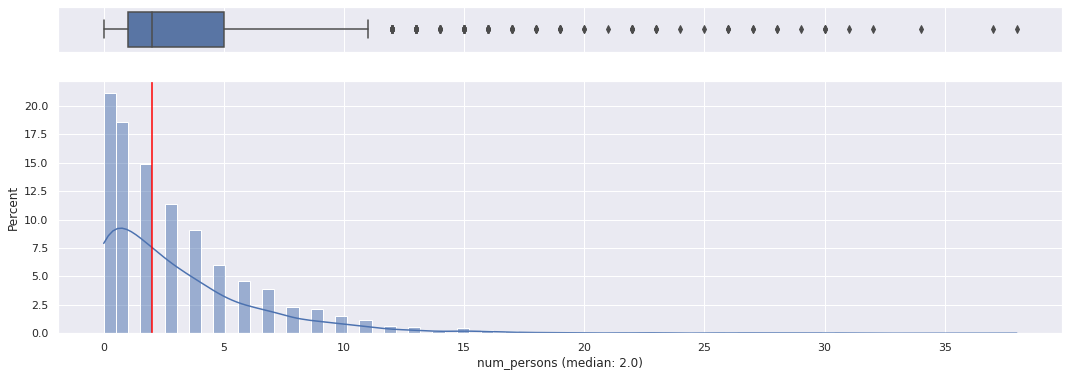

In [51]:
draw_boxplot_histogram(article_df, "num_persons")

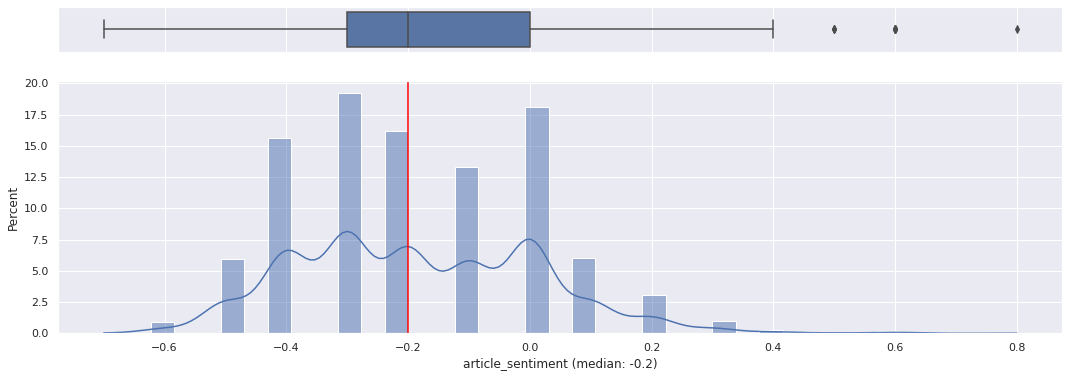

In [52]:
draw_boxplot_histogram(article_df, "article_sentiment")

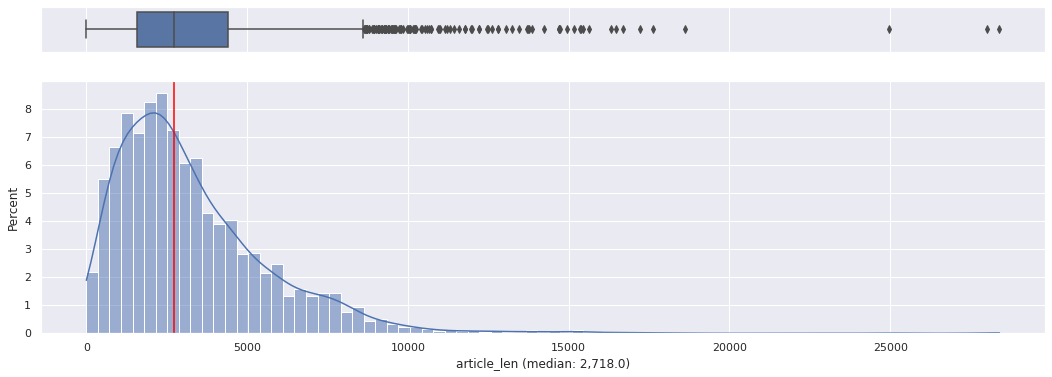

In [53]:
draw_boxplot_histogram(article_df, "article_len")

# Load to BQ

In [54]:
article_df["insert_datetime"] = pd.Timestamp.now()
article_df["publish_date"] = pd.to_datetime(article_df["publish_date"])

In [76]:
article_df = article_df[["insert_datetime", "publish_date", "title", "article_source_link", "article_sentiment", "persons"]]

In [82]:
job_config = bigquery.LoadJobConfig(
    schema=SCHEMA,
    write_disposition="WRITE_TRUNCATE",
)

job = bq_client.load_table_from_dataframe(
    article_df2, "aliz-ml-spec-2022-dev.ml_specialization.articles", job_config=job_config
)  # Make an API request.
job.result()  # Wait for the job to complete.


LoadJob<project=aliz-ml-spec-2022-dev, location=US, id=0e072a3b-91ba-484b-ae30-39c612104bc1>

In [83]:
job.done()

True